In [105]:
#convert that column to int, showing which element is not a number

In [106]:
import numpy as np
import pandas as pd


from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.gaussian_process import GaussianProcessRegressor

import pickle

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
%matplotlib inline
import scipy


In [107]:
def preprocess(file_path,y_label,ratio= 0.7):
    
    tr_te = pd.read_excel(file_path, sheetname='Sheet1')
    tr_te = pd.get_dummies(tr_te)
    tr_te = tr_te.loc[:, tr_te.var() != 0.0]
    tr_te  = tr_te.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    X = tr_te.drop(['runtime','ev_rolledback'], axis = 1)
    features = X.columns
    X = X.values
    Y = tr_te[y_label].values

    num = X.shape[0]
    num_tr = int(num*ratio)

    xtrain = X[:num_tr,:]
    y = Y[:num_tr]
    xtest = X[num_tr:]
    ytest = Y[num_tr:]
    return (xtrain,y,xtest,ytest)

In [112]:
def cross_val(xtrain,y,xtest):
    nfolds = 5
    folds = KFold(len(y), n_folds = nfolds, shuffle = True, random_state = 2018)

    # create two arrays to hold the prediction on training set and testing set
    preds_train = np.zeros(xtrain.shape[0])
    preds_test = np.zeros(xtest.shape[0])

    fold_index = 1
    for (inTr, inVal) in folds:
        # split the training set 
        xtr = xtrain[inTr]
        ytr = y[inTr]
        xval = xtrain[inVal] 
        yval = y[inVal]

        # Define a isotropic Matern kernel
        kernel_Matern = 1.0 * Matern([1.0]*xtrain.shape[1])

        # train and save the trained model
        file_name = '../trained_model/gp'+str(fold_index)+".sav"
        gp = GaussianProcessRegressor(kernel = kernel_Matern, n_restarts_optimizer=1)
        gp.fit(xtr, ytr)
        pickle.dump(gp, open(file_name, 'wb'))

        # predict on the validation set
        pred = gp.predict(xval, return_std=False)
        score = mean_absolute_error(yval, pred)
        preds_train[inVal] = pred
        print('Fold ', fold_index, '- MAE:', score)
        fold_index += 1
        preds_test += gp.predict(xtest,return_std = False)

    # average and save the predictions on testing set 
    preds_test /= nfolds 
    return (preds_test,preds_train)
 

In [114]:
def visualize_pre(ytest,preds_test):
    fig = plt.figure(figsize= (6,4))

    plt.scatter(ytest,preds_test)
    plt.xlabel('Truth')
    plt.ylabel('Prediction')

    PCC = round(scipy.stats.pearsonr(ytest,preds_test)[0],3)

    plt.text(np.min(ytest)*1.1, 0.95*np.max(preds_test), r'PCC='+str(PCC),
             fontsize=10)

Fold  1 - MAE: 1.73188703022e-05


/home/wxk/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.54167849e-03,  -3.02889208e+00,  -1.49927434e-01,
        -1.19316811e-02,  -2.88431671e-01,  -9.48100716e-01,
        -1.23414656e-02,  -7.48593659e-03,  -1.58438885e-02,
        -1.10054219e-01,  -3.58399328e-03,   1.50629911e-02,
        -2.33102051e-02,  -5.61442432e-03,  -5.61442432e-03,
        -2.77989029e+00,  -2.45863654e+00,  -3.04619763e+00,
        -4.66082548e-05,  -0.00000000e+00,  -8.43437689e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 34, 'warnflag': 2}
  " state: %s" % convergence_dict)


Fold  2 - MAE: 2.95910665118e-06
Fold  3 - MAE: 1.49760694584e-06
Fold  4 - MAE: 5.9332078357e-05
Fold  5 - MAE: 1.37202936593e-06


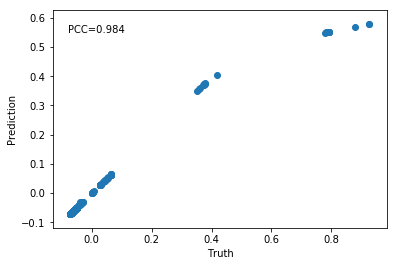

In [119]:
file_path = "../data/dfly-scaling-data.xlsx"
xtrain, y, xtest,ytest = preprocess(file_path,'runtime')
preds_test, preds_train = cross_val(xtrain,y,xtest)
visualize_pre(ytest,preds_test)

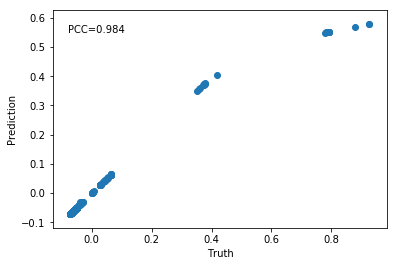

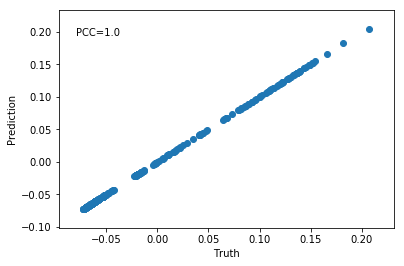

In [104]:
# visualize the prediction on the training set
fig = plt.figure(figsize= (6,4))

plt.scatter(y,preds_train)
plt.xlabel('Truth')
plt.ylabel('Prediction')

PCC = round(scipy.stats.pearsonr(y,preds_train)[0],3)

plt.text(np.min(y)*1.1, 0.95*np.max(preds_train), r'PCC='+str(PCC),
         fontsize=10)